In [1]:
%matplotlib inline


GLM fitting in second level fMRI
================================

Full step-by-step example of fitting a GLM to perform a second level analysis
in experimental data and visualizing the results.

More specifically:

1. A sequence of subject fMRI button press contrasts is downloaded.
2. a mask of the useful brain volume is computed
3. A one-sample t-test is applied to the brain maps

(as fixed effects, then contrast estimation)

Author : Martin Perez-Guevara: 2016



In [2]:
import pandas as pd
from nilearn import plotting
from scipy.stats import norm
import matplotlib.pyplot as plt

from nilearn.datasets import fetch_localizer_contrasts
from nistats.second_level_model import SecondLevelModel

Fetch dataset
--------------
We download a list of left vs right button press contrasts from a
localizer dataset.



In [3]:
n_subjects = 16
data = fetch_localizer_contrasts(["left vs right button press"], n_subjects,
                                 get_tmaps=True)

/Users/Ralf/anaconda2/envs/my_py36_env/lib/python3.6/site-packages/numpy/lib/npyio.py:2258: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


Display subject t_maps
----------------------
We plot a grid with all the subjects t-maps thresholded at t = 2 for
simple visualization purposes. The button press effect is visible among
all subjects



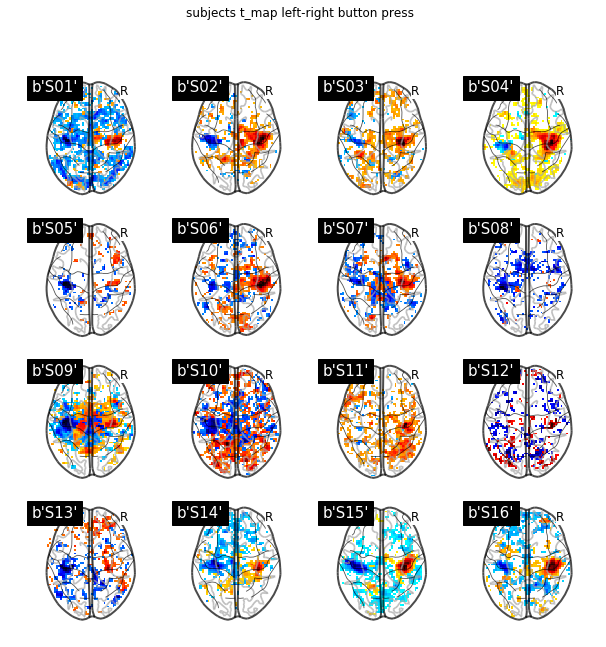

In [4]:
subjects = [subject_data[0] for subject_data in data['ext_vars']]
fig, axes = plt.subplots(figsize = (10,10), nrows=4, ncols=4)
for cidx, tmap in enumerate(data['tmaps']):
    plotting.plot_glass_brain(tmap, colorbar=False, threshold=2.0,
                              title=subjects[cidx],
                              axes=axes[int(cidx / 4), int(cidx % 4)],
                              plot_abs=False, display_mode='z')
fig.suptitle('subjects t_map left-right button press')
plt.show()

Estimate second level model
---------------------------
We define the input maps and the design matrix for the second level model
and fit it.



In [5]:
second_level_input = data['cmaps']
design_matrix = pd.DataFrame([1] * len(second_level_input),
                             columns=['intercept'])

second_level_model = SecondLevelModel(smoothing_fwhm=8.0)
second_level_model = second_level_model.fit(second_level_input,
                                            design_matrix=design_matrix)

/Users/Ralf/anaconda2/envs/my_py36_env/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


To estimate the contrast is very simple. We can just provide the column
name of the design matrix.



In [6]:
z_map = second_level_model.compute_contrast(output_type='z_score')

/Users/Ralf/anaconda2/envs/my_py36_env/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/Ralf/anaconda2/envs/my_py36_env/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/Ralf/anaconda2/envs/my_py36_env/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


We threshold the second level contrast at uncorrected p < 0.001 and plot



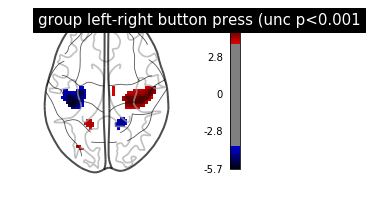

In [7]:
p_val = 0.00005
z_th = norm.isf(p_val)
display = plotting.plot_glass_brain(
    z_map, threshold=z_th, colorbar=True, plot_abs=False, display_mode='z',
    title='group left-right button press (unc p<0.001')

plotting.show()

In [10]:
z_map.to_filename('/Users/Ralf/Desktop/zma.nii')